In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 7650
lag_exp=24

In [3]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:
import pandas as pd
data = pd.read_csv('cbe1.csv',index_col="DateTime")
data.head()

,AirTemperature,WindSpeed,WindDirection
DateTime,,,
15-02-2016 01:00,25.4,1.6,255.0
15-02-2016 02:00,24.8,1.4,273.0
15-02-2016 03:00,24.1,0.7,347.0
15-02-2016 04:00,23.1,1.6,286.0
15-02-2016 05:00,22.5,1.6,275.0


In [11]:

del data['WindDirection']
del data['AirTemperature']
data.head()

,WindSpeed
DateTime,
15-02-2016 01:00,1.6
15-02-2016 02:00,1.4
15-02-2016 03:00,0.7
15-02-2016 04:00,1.6
15-02-2016 05:00,1.6


In [12]:
for i in range(0,10):
  data = data[:-1]
data.tail()

,WindSpeed
DateTime,
03-01-2020 21:00,0.6
03-01-2020 22:00,0.6
03-01-2020 23:00,0.9
04-01-2020 00:00,2.3
04-01-2020 01:00,2.1


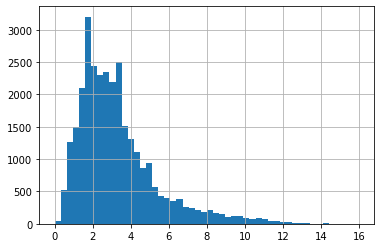

In [13]:
data['WindSpeed'].hist(bins=50)

In [14]:
data.size

30590

In [15]:
data.shape

(30590, 1)

In [16]:
raw_values = data.values
diff_values = difference(raw_values, 1)

In [17]:
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [18]:
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]


In [19]:
scaler, train_scaled, test_scaled = scale(train, test)

In [20]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
22939/22939 [==============================] - 67s 3ms/step - loss: 0.0142
Epoch 1/1
22939/22939 [==============================] - 65s 3ms/step - loss: 0.0139
Epoch 1/1
22939/22939 [==============================] - 37s 2ms/step - loss: 0.0137
Epoch 1/1
22939/22939 [==============================] - 31s 1ms/step - loss: 0.0136
Epoch 1/1
22939/22939 [==============================] - 34s 1ms/step - loss: 0.0135
Epoch 1/1
22939/22939 [==============================] - 35s 2ms/step - loss: 0.0135
Epoch 1/1
22939/22939 [==============================] - 36s 2ms/step - loss: 0.0134


In [21]:
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    expected = raw_values[len(train) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Hour=1, Predicted=1.268790, Expected=1.400000
Hour=2, Predicted=1.294904, Expected=1.400000
Hour=3, Predicted=1.330056, Expected=1.400000
Hour=4, Predicted=1.361368, Expected=1.400000
Hour=5, Predicted=1.389322, Expected=1.400000
Hour=6, Predicted=1.410390, Expected=1.400000
Hour=7, Predicted=1.420135, Expected=1.400000
Hour=8, Predicted=1.426925, Expected=1.400000
Hour=9, Predicted=1.431489, Expected=1.400000
Hour=10, Predicted=1.433985, Expected=1.400000
Hour=11, Predicted=1.430925, Expected=1.400000
Hour=12, Predicted=1.427904, Expected=1.400000
Hour=13, Predicted=1.423286, Expected=1.400000
Hour=14, Predicted=1.419940, Expected=1.400000
Hour=15, Predicted=1.420858, Expected=1.400000
Hour=16, Predicted=1.420361, Expected=1.400000
Hour=17, Predicted=1.421351, Expected=1.400000
Hour=18, Predicted=1.415208, Expected=1.400000
Hour=19, Predicted=1.408954, Expected=1.400000
Hour=20, Predicted=1.405044, Expected=1.400000
Hour=21, Predicted=1.401455, Expected=1.400000
Hour=22, Predicted=1.3

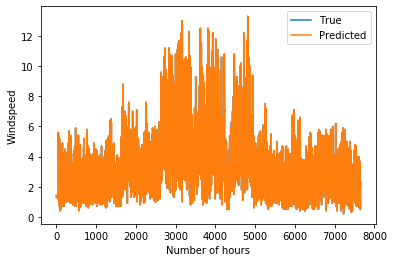

In [22]:
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Windspeed")
pyplot.show()

In [23]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  0.22832281233505727


In [24]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(expectations, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(expectations, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(expectations, predictions)))

Mean Absolute Error: 0.6505657584173543
Mean Squared Error: 0.8233503205311513
Root Mean Squared Error: 0.9073865331440352
